## 멀티턴 에이전트 그래프
- LLM이 툴 호출이 필요하면 툴 노드로 분기
- 툴 실행 후 다시 에이전트로 돌아와 추가 reasoning을 반복
- 더 이상 툴 호출이 없으면 그래프가 종료되고, 최종 답변이 출력

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", streaming=True)
small_llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

### 툴(함수) 정의 및 등록

In [ ]:
from langchain_core.tools import tool

# add(a, b): 두 수를 더하는 함수
@tool
def add(a: int, b: int) -> int:
    """숫자 a와 b를 더합니다."""
    return a+b

# multiply(a, b): 두 수를 곱하는 함수
@tool
def multiply(a: int, b: int) -> int:
    """숫자 a와 b를 곱합니다."""
    return a*b

In [ ]:
from langgraph.prebuilt import ToolNode

# 위 두 함수를 LangChain의 @tool 데코레이터로 툴로 등록
tool_list = [add, multiply]
#툴 리스트를 만들고, LLM에 툴을 바인딩(llm_with_tools)
llm_with_tools = small_llm.bind_tools(tool_list)
#ToolNode로 툴 실행 노드를 만듦
tool_node = ToolNode(tool_list)

### 툴 및 LLM 테스트

In [ ]:
multiply.invoke({'a':3, 'b':5})

15

In [ ]:
#LLM이 툴 호출 메시지를 생성하는지 테스트
ai_message = llm_with_tools.invoke('What is 3 plus 5?')

In [7]:
ai_message

AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_w8eBXC6xsRx9H35kjU2R1BUp', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_62a23a81ef'}, id='run--ce597ba6-2747-4065-a1aa-4493dfeb0432-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_w8eBXC6xsRx9H35kjU2R1BUp', 'type': 'tool_call'}])

In [8]:
tool_node.invoke({'messages': [ai_message]}) #'What is 3 plus 5?' 질의에 대한 tool_calls에 대한 정보를 messages에 넣는 것

{'messages': [ToolMessage(content='8', name='add', tool_call_id='call_w8eBXC6xsRx9H35kjU2R1BUp')]}

### 그래프 상태 및 빌더 준비

In [ ]:
from langgraph.graph import MessagesState, StateGraph
#MessagesState : system, human, ai, tool message를 저장
#여러 메시지 유형(시스템, 사용자, AI, 툴 메시지 등)을 저장하고 관리하는 데 사용되는 상태 타입

#StateGraph(MessagesState)로 그래프 빌더 생성
graph_builder = StateGraph(MessagesState)

### 에이전트 노드 정의

In [ ]:
#agent(state) 함수

def agent(state: MessagesState) -> MessagesState:
    """
    에이전트 함수는 주어진 상태에서 메세지를 가져와
    LLM과 도구를 사용하여 응답 메세지를 생성합니다.

    Args:
        state (MessagesState) : 메세지 상태를 포함하는 state.

    Returns:
        MessageState: 응답 메세지를 포함하는 새로운 state.
    
    """

    messages = state['messages']
    #현재 메시지 리스트를 LLM에 전달

    response = llm_with_tools.invoke(messages)
    #LLM이 응답 메시지(툴 호출 포함 가능)를 생성

    return {"messages": [response]}
    #새로운 메시지 상태로 반환

### 분기(조건) 노드 정의

In [ ]:
from typing import Literal
from langgraph.graph import END

#should_continue(state) 함수
def should_continue(state: MessagesState) -> Literal['tools', END]:
    """
    주어진 메세지 상태를 기반으로 agent가 계속 진행할지 여부를 결정한다.
    
    Args:
        state (MessagesState) : 'state'를 포함하는 객체
    
    Returns:
        Literal['tools', END]: 도구를 사용해야하면 'tools'를 리턴하고,
        답변할 준비가 되었다면 END를 반환해서 프로세스를 종료합니다.

    """

    messages = state['messages']
    last_ai_message = messages[-1]

    if last_ai_message.tool_calls:
        return 'tools'
        #마지막 AI 메시지에 tool_calls가 있으면 'tools'로 분기

    return END
    #없으면 END로 분기(그래프 종료)


### 그래프 노드 및 에지 연결

In [ ]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [13]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent',
    should_continue, #이것이 판단 #tool_calls가 있으면 tools로 가고 agent로 감
    ['tools', END]
)
graph_builder.add_edge('tools', 'agent')



In [14]:
graph = graph_builder.compile()

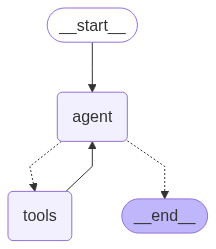

In [15]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에 5를 더하고 8을 곱하면?')]}, stream_mode='values'): # chunk에 담으려고 함
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에 5를 더하고 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_VKIFwtyRJHxAJgbAzhNeHNws)
 Call ID: call_VKIFwtyRJHxAJgbAzhNeHNws
  Args:
    a: 3
    b: 5
  multiply (call_jA6ZlCIQwrb1xBbc6vg53zb5)
 Call ID: call_jA6ZlCIQwrb1xBbc6vg53zb5
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

3에 5를 더하면 8이고, 8을 곱하면 64입니다.
